In [34]:
import requests
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
import graphing

import plotly.express as px

import plotly.graph_objects as go


from datetime import datetime

from mpl_toolkits import mplot3d

import statsmodels.formula.api as smf
import missingno as msno
# from m1b_gradient_descent import gradient_descent
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, export_text

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

from sklearn.metrics import confusion_matrix, classification_report, log_loss, mean_squared_error, mean_absolute_error, r2_score, make_scorer

In [8]:
def download_file(url, filename):
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if the request was successful
    response.raise_for_status()  # This will raise an exception for HTTP errors
    
    # Write the content to a file
    with open(filename, 'wb') as f:
        f.write(response.content)




In [9]:
url_1 = r"https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/avalanche.csv"


download_file(url_1, 'avalanche.csv')

In [11]:
#Import the data from the .csv file
dataset = pd.read_csv('avalanche.csv', delimiter="\t")

#Let's have a look
dataset

,Unnamed: 0,avalanche,no_visitors,surface_hoar,fresh_thickness,wind,weak_layers,tracked_out
0,0,0,4,3.900508,8.715485,6,9,0
1,1,0,9,1.477586,6.801417,30,0,0
2,2,1,3,3.236594,5.632457,8,8,1
3,3,0,0,3.244283,9.348871,12,10,0
4,4,1,2,5.196741,3.782315,4,9,1
...,...,...,...,...,...,...,...,...
1090,1090,1,1,2.182905,6.109184,3,9,0
1091,1091,0,2,3.718231,10.426100,28,0,0
1092,1092,1,8,7.037647,9.741006,34,3,0
1093,1093,0,2,2.449889,7.337579,37,10,1


In [12]:
graphing.box_and_whisker(dataset, label_x="avalanche", label_y="surface_hoar", show=True)
graphing.box_and_whisker(dataset, label_x="avalanche", label_y="fresh_thickness", show=True)
graphing.box_and_whisker(dataset, label_x="avalanche", label_y="weak_layers", show=True)
graphing.box_and_whisker(dataset, label_x="avalanche", label_y="no_visitors")

We can notice that:

- For `fresh_thickness` the outcomes are very similar. This means that variations in their values aren't strongly correlated with the results.

- Variations in values for `weak_layers` and `no_visitors`, seem to correlate with a larger number of `avalanche` results, and thus we should assign more importance to these features.

The differences between avalanche and non-avalanche days are small and there isn't one clear driver of issues. Weak layers looks like a good starting point as it is related to the widest variation in results.

## Building a simple logistic regression model

We will now built and train a model to predict the chance of an avalanche happening based __solely__ on the number of weak layers of snow:

In [13]:
# Here we import a function that splits datasets according to a given ratio
from sklearn.model_selection import train_test_split

# Split the dataset in an 70/30 train/test ratio. 
train, test = train_test_split(dataset, test_size=0.3, random_state=2)
print(train.shape)
print(test.shape)

(766, 8)
(329, 8)


In [14]:
# Perform logistic regression.
model = smf.logit("avalanche ~ weak_layers", train).fit()

print("Model trained")

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.631451
         Iterations 5
Model trained
                           Logit Regression Results                           
Dep. Variable:              avalanche   No. Observations:                  766
Model:                          Logit   Df Residuals:                      764
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Jan 2025   Pseudo R-squ.:                 0.07898
Time:                        15:02:53   Log-Likelihood:                -483.69
converged:                       True   LL-Null:                       -525.17
Covariance Type:            nonrobust   LLR p-value:                 8.395e-20
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.8586      0.147     -5.856      0.000      -1.146      -0.571
weak_layers 

## Using our model

We can now use our trained model to make predictions and estimate probabilities.

Let's pick the first four occurrences in our `test` set and print the probability of an avalanche for each one of them:

In [15]:
# predict to get a probability

# get first 3 samples from dataset
samples = test["weak_layers"][:4]

# use the model to get predictions as possibilities
estimated_probabilities = model.predict(samples)

# Print results for each sample
for sample, pred in zip(samples,estimated_probabilities):
    print(f"A weak_layer with value {sample} yields a {pred * 100:.2f}% chance of an avalanche.")


A weak_layer with value 5 yields a 56.51% chance of an avalanche.
A weak_layer with value 4 yields a 50.95% chance of an avalanche.
A weak_layer with value 7 yields a 67.05% chance of an avalanche.
A weak_layer with value 0 yields a 29.76% chance of an avalanche.


In [17]:
# plot the model
# Show a graph of the result
predict = lambda x: model.predict(pd.DataFrame({"weak_layers": x}))

graphing.line_2D([("Model", predict)],
                 x_range=[-20,40],
                 label_x="weak_layers", 
                 label_y="estimated probability of an avalanche")

In [18]:
# Get actual rates of avalanches at 0 layers
avalanche_outcomes_for_0_layers = train[train.weak_layers == 0].avalanche
print("Average rate of avalanches for 0 weak layers of snow", np.average(avalanche_outcomes_for_0_layers))

# Get actual rates of avalanches at 10 layers
avalanche_outcomes_for_10_layers = train[train.weak_layers == 10].avalanche
print("Average rate of avalanches for 10 weak layers of snow", np.average(avalanche_outcomes_for_10_layers))

Average rate of avalanches for 0 weak layers of snow 0.3880597014925373
Average rate of avalanches for 10 weak layers of snow 0.7761194029850746


## Classification or decision thresholds
To return a binary category (`True` = "avalanche", `False` = "no avalanche") we need to define a *Classification Threshold* value. Any probability above that threshold is returned as the positive category, whereas values below it will be returned as the negative category.

Let's see what happens if set our threshold to `0.5` (meaning that our model will return `True` whenever it calculates a chance above 50% of an avalanche happening):

In [19]:
# threshold to get an absolute value
threshold = 0.5

# Add classification to the samples we used before
for sample, pred in list(zip(samples,estimated_probabilities)):
    print(f"A weak_layer with value {sample} yields a chance of {pred * 100:.2f}% of an avalanche. Classification = {pred > threshold}")



A weak_layer with value 5 yields a chance of 56.51% of an avalanche. Classification = True
A weak_layer with value 4 yields a chance of 50.95% of an avalanche. Classification = True
A weak_layer with value 7 yields a chance of 67.05% of an avalanche. Classification = True
A weak_layer with value 0 yields a chance of 29.76% of an avalanche. Classification = False


## Performance on test set
Now let's use our `test` dataset to perform a quick evaluation on how the model did. For now, we'll just look at how often we correctly predicted if there would be an avalanche or not

In [20]:
# Classify the mdel predictions using the threshold - > creates a boolean array
predictions = model.predict(test) > threshold

# Compare the predictions to the actual outcomes in the dataset
accuracy = np.average(predictions == test.avalanche)

# Print the evaluation
print(f"The model correctly predicted outcomes {accuracy * 100:.2f}% of time.")

The model correctly predicted outcomes 65.05% of time.


In [22]:
conf_matrix = confusion_matrix(test.avalanche, predictions)

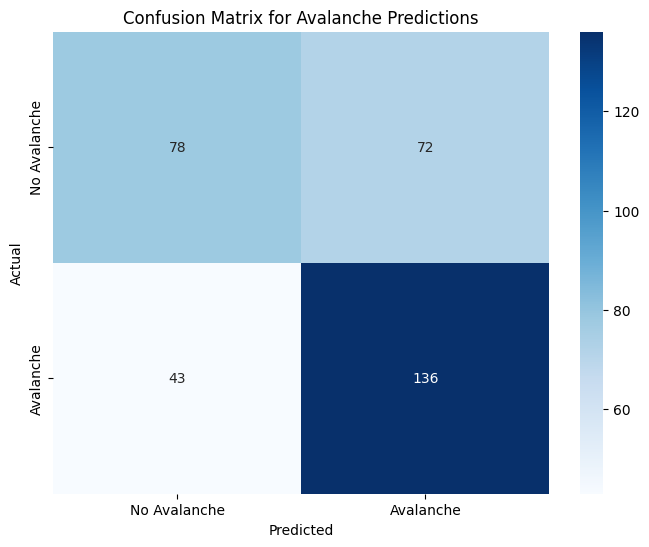

In [23]:
# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, 
            annot=True,  # Show numbers in cells
            fmt='d',     # Use integer format
            cmap='Blues',# Use blue color scheme
            xticklabels=['No Avalanche', 'Avalanche'],
            yticklabels=['No Avalanche', 'Avalanche'])
plt.title('Confusion Matrix for Avalanche Predictions')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

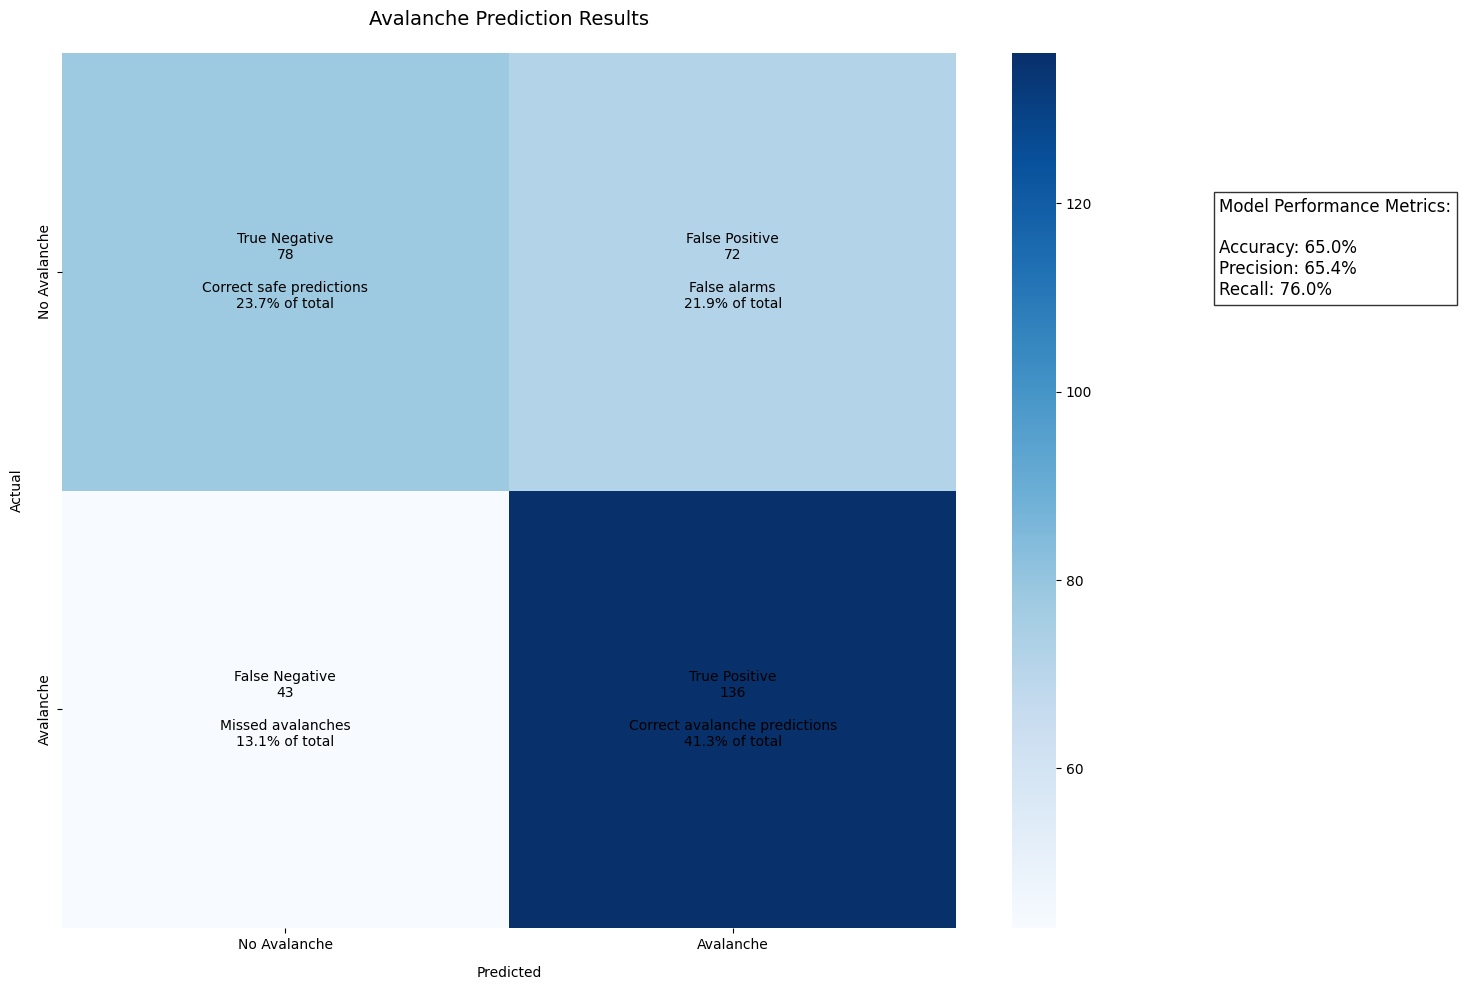

In [28]:
# Create confusion matrix
conf_matrix = confusion_matrix(test.avalanche, predictions)

# Calculate metrics for display
total = np.sum(conf_matrix)
accuracy = (conf_matrix[0][0] + conf_matrix[1][1]) / total
precision = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1])
recall = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])

# Create figure with subplots - main plot for matrix, extra space for metrics
fig, ax = plt.subplots(figsize=(12, 10))

# Create the heatmap
sns.heatmap(conf_matrix, 
            annot=False,
            cmap='Blues',
            xticklabels=['No Avalanche', 'Avalanche'],
            yticklabels=['No Avalanche', 'Avalanche'],
            ax=ax)

# Add detailed information to each cell
labels = [['True Negative', 'False Positive'],
          ['False Negative', 'True Positive']]

for i in range(2):
    for j in range(2):
        text = f'{labels[i][j]}\n{conf_matrix[i][j]}\n\n'
        if i == 0 and j == 0:  # True Negatives
            text += f'Correct safe predictions\n{(conf_matrix[i][j]/total):,.1%} of total'
        elif i == 0 and j == 1:  # False Positives
            text += f'False alarms\n{(conf_matrix[i][j]/total):,.1%} of total'
        elif i == 1 and j == 0:  # False Negatives
            text += f'Missed avalanches\n{(conf_matrix[i][j]/total):,.1%} of total'
        else:  # True Positives
            text += f'Correct avalanche predictions\n{(conf_matrix[i][j]/total):,.1%} of total'
            
        ax.text(j + 0.5, i + 0.5, text,
                ha='center',
                va='center')

# Add metrics as text box in the figure
metrics_text = (f'Model Performance Metrics:\n\n'
               f'Accuracy: {accuracy:.1%}\n'
               f'Precision: {precision:.1%}\n'
               f'Recall: {recall:.1%}')

plt.figtext(1.02, 0.7, metrics_text, 
            bbox=dict(facecolor='white', alpha=0.8),
            fontsize=12)

# Set titles and labels
plt.title('Avalanche Prediction Results', pad=20, fontsize=14)
plt.xlabel('Predicted', labelpad=10)
plt.ylabel('Actual', labelpad=10)

# Adjust layout to make room for metrics
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
graphing.box_and_whisker(dataset, label_x="avalanche", label_y="weak_layers")

In [30]:
# Split the dataset in an 75/25 train/test ratio. 
train, test = train_test_split(dataset, test_size=0.25, random_state=10)

print("Train size:", train.shape[0])
print("Test size:", test.shape[0])

Train size: 821
Test size: 274


In [31]:
# Perform logistic regression.
model = smf.logit("avalanche ~ weak_layers", train).fit()

print("Model trained")
model.summary()

Optimization terminated successfully.
         Current function value: 0.616312
         Iterations 5
Model trained


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              avalanche   No. Observations:                  821
Model:                          Logit   Df Residuals:                      819
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Jan 2025   Pseudo R-squ.:                  0.1018
Time:                        20:16:54   Log-Likelihood:                -505.99
converged:                       True   LL-Null:                       -563.33
Covariance Type:            nonrobust   LLR p-value:                 9.269e-27
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.0656      0.148     -7.207      0.000      -1.355      -0.776
weak_layers     0.2643      0.026      9.985      0.000       0.212       0.316
===============================================================================
"""

This summary provides some detailed information. 

Two useful pieces of information are in the bottom row. The coef for `weak_layers` is positive, which means that as `weak_layers` increases, so does the probability of an avalanche. The `P` value column is less than 0.05, which means the model is confident that `weak_layers` is a useful predictor of avalanches. 

The rest of this table, however, is difficult to understand for beginners and so it's not clear how well our model is working. Let's try another way. 

## Assessing model visually

Sometimes, but not always, we can visually assess a logistic regression mode. Let's plot our model against the actual data in the test dataset.

In [32]:
def predict(weak_layers):
    return model.predict(dict(weak_layers=weak_layers))

graphing.scatter_2D(test, label_x="weak_layers", label_y="avalanche", trendline=predict)

In [33]:
graphing.scatter_2D(test, label_x="weak_layers", label_y="avalanche", x_range=[-20,20], trendline=predict)

In [35]:
# Make predictions from the test set
predictions = model.predict(test)

# Calculate log loss
print("Log loss", log_loss(test.avalanche, predictions))

Log loss 0.6803588691541006


0.68 - what does that mean? This could be useful to compare two different models, but it's hard to get a grasp on exactly what this means for real-world performance. 

## Assess accuracy

Let's instead assess _accuracy_. Accuracy refers to the _proportion of predictions the model got correct_, after predictions are converted from probabilities to `avalanche` or `no-avalanche`.

The first thing to do is convert probabilities to hard predictions:

In [36]:
# Print a few predictions before we convert them to categories
print(f"First three predictions (probabilities): {predictions.iloc[0]}, {predictions.iloc[1]}, {predictions.iloc[2]}")

# convert to absolute values
avalanche_predicted = predictions >= 0.5

# Print a few predictions converted into categories
print(f"First three predictions (categories): {avalanche_predicted.iloc[0]}, {avalanche_predicted.iloc[1]}, {avalanche_predicted.iloc[2]}")

First three predictions (probabilities): 0.788017694282122, 0.6866335148335762, 0.5636126304803127
First three predictions (categories): True, True, True


In [37]:
# Calculate what proportion were predicted correctly
guess_was_correct = test.avalanche == avalanche_predicted
accuracy = np.average(guess_was_correct)

# Print the accuracy
print("Accuracy for whole test dataset:", accuracy)

Accuracy for whole test dataset: 0.6167883211678832


In [39]:
# False Negative: calculate how often it guessed no avalanche when one actually occurred
false_negative = np.average(np.logical_not(guess_was_correct) & test.avalanche)

# False positive: calculate how often it guessed avalanche, when none actually happened
false_positive = np.average(np.logical_not(guess_was_correct) & np.logical_not(test.avalanche))


print(f"Wrongly predicted an avalanche {false_positive * 100}% of the time")
print(f"Failed to predict avalanches {false_negative * 100}% of the time")

Wrongly predicted an avalanche 17.153284671532848% of the time
Failed to predict avalanches 21.16788321167883% of the time
